In [29]:
# Initialize Faker
fake = Faker()

# Define the number of transactions
num_transactions = 1000

# Generate random transaction data
data = []
for _ in range(num_transactions):
    transaction = {
        "Transaction_ID": fake.uuid4(),
        "User_ID": fake.random_int(min=1000, max=9999),
        "Amount": round(random.uniform(10, 5000), 2),
        "Transaction_Type": random.choice(["Online Purchase", "ATM Withdrawal", "Bank Transfer", "Bill Payment"]),
        "Timestamp": fake.date_time(),  # ✅ Includes both date & time
        "Location": fake.city(),
        "Fraudulent": random.choice([0, 1])  # 0 = Legit, 1 = Fraudulent
    }
    data.append(transaction)

# Convert to DataFrame
df = pd.DataFrame(data)



In [30]:
# Convert Timestamp column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Extract numerical features from the Timestamp
df["Year"] = df["Timestamp"].dt.year
df["Month"] = df["Timestamp"].dt.month
df["Day"] = df["Timestamp"].dt.day
df["Hour"] = df["Timestamp"].dt.hour  # ✅ Works because time is included


In [31]:
df.to_csv("synthetic_transactions.csv", index=False)


In [32]:
df = pd.read_csv("synthetic_transactions.csv")

# Ensure Timestamp is in datetime format after reloading
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Display first 5 rows
df.head()


,Transaction_ID,User_ID,Amount,Transaction_Type,Timestamp,Location,Fraudulent,Year,Month,Day,Hour
0,30f91390-9490-4767-9f74-f1751ad88bb3,1452,1566.49,Bank Transfer,2010-04-20 23:10:44.939623,Hunterfurt,0,2010,4,20,23
1,1796aee7-d9ce-4cae-aece-a1e2f27409e3,3039,496.47,Bank Transfer,1983-09-13 08:58:14.293984,North Markside,0,1983,9,13,8
2,60343eb1-75f2-4c78-a2b7-022a8188b402,2505,1174.76,Bank Transfer,1991-03-12 18:43:34.839872,Larryport,1,1991,3,12,18
3,9c6b7ece-e316-4b43-9fc9-22cc225633c9,2481,2790.92,Bill Payment,2016-07-20 20:43:09.491135,Tyroneton,1,2016,7,20,20
4,074ed3ee-fa14-47d8-aecc-520e8cccc4eb,5612,604.11,Bill Payment,2003-06-26 12:39:40.953212,Waltersstad,0,2003,6,26,12


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


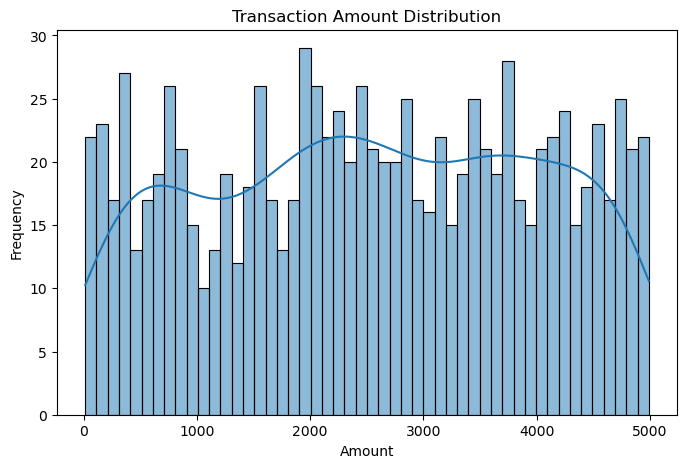

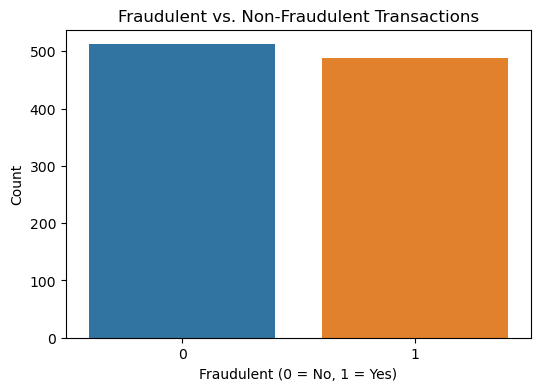

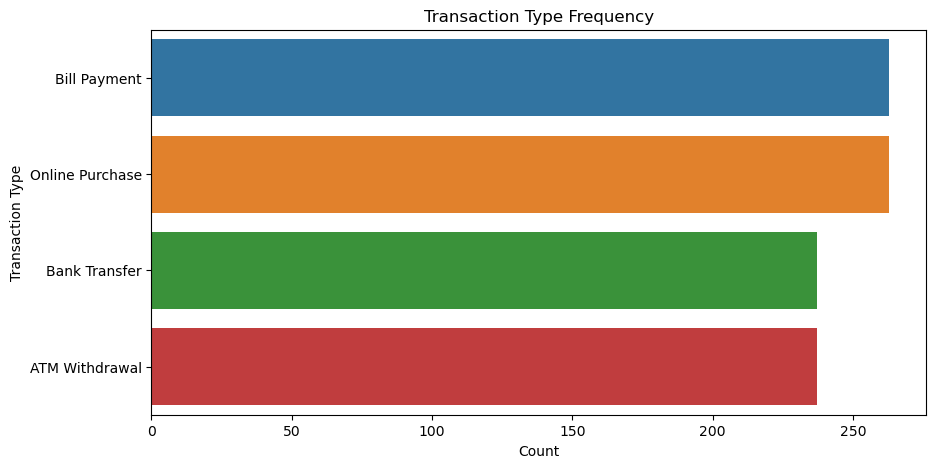

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transaction amount distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Fraudulent vs. Legit Transactions
plt.figure(figsize=(6, 4))
sns.countplot(x="Fraudulent", data=df)
plt.title("Fraudulent vs. Non-Fraudulent Transactions")
plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Transaction Type Frequency
plt.figure(figsize=(10, 5))
sns.countplot(y="Transaction_Type", data=df, order=df["Transaction_Type"].value_counts().index)
plt.title("Transaction Type Frequency")
plt.ylabel("Transaction Type")
plt.xlabel("Count")
plt.show()


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert Timestamp column to datetime format (if not already converted)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Feature Engineering: Extract numerical features from Timestamp
df["Year"] = df["Timestamp"].dt.year
df["Month"] = df["Timestamp"].dt.month
df["Day"] = df["Timestamp"].dt.day
df["Hour"] = df["Timestamp"].dt.hour
df["Minute"] = df["Timestamp"].dt.minute
df["Second"] = df["Timestamp"].dt.second
df["Day_of_Week"] = df["Timestamp"].dt.weekday  # Monday=0, Sunday=6
df["Is_Weekend"] = df["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend, 0 = Weekday

# Drop original Timestamp column
df.drop(columns=["Timestamp"], inplace=True)

# Define Features and Target
X = df.drop(columns=["Transaction_ID", "Fraudulent", "Location", "Transaction_Type"], errors="ignore")  # Features
y = df["Fraudulent"]  # Target variable (binary: 0 or 1)

# Verify no datetime columns in X
assert not np.issubdtype(X.dtypes.values.any(), np.datetime64), "❌ Timestamp is still in X!"

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # ✅ Now works with numerical time-based features

# Make predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5166666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.62      0.56       151
           1       0.52      0.41      0.46       149

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.51       300
weighted avg       0.52      0.52      0.51       300



In [37]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate optimized model
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_best))
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Optimized Accuracy: 0.54
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.63      0.58       151
           1       0.54      0.45      0.49       149

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.54       300
weighted avg       0.54      0.54      0.54       300



In [38]:
import joblib

# Save the trained model
joblib.dump(best_model, "fraud_detection_model.pkl")

# Load the model when needed
loaded_model = joblib.load("fraud_detection_model.pkl")
